In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qmcpy as qp

In [2]:
seed = 7

# Comparison of multilevel (Quasi-)Monte Carlo for an Asian option problem

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QMCSoftware/QMCSoftware/blob/develop/demos/asian-option-mlqmc.ipynb)

Compute the exact value of the Asian option with single level QMC, for an increasing number of time steps:

In [4]:
for level in range(5):
    aco = qp.FinancialOption(qp.Sobol(2*2**level, seed=seed), option="ASIAN", volatility=.2, start_price=100, strike_price=100, interest_rate=.05)
    approx_solution, data = qp.CubQMCSobolG(aco, abs_tol=1e-4).integrate()
    print("Asian Option true value (%d time steps): %.5f (to within 1e-4)"%(2*2**level, approx_solution))

Asian Option true value (2 time steps): 5.63593 (to within 1e-4)
Asian Option true value (4 time steps): 5.73171 (to within 1e-4)
Asian Option true value (8 time steps): 5.75526 (to within 1e-4)
Asian Option true value (16 time steps): 5.76112 (to within 1e-4)
Asian Option true value (32 time steps): 5.76260 (to within 1e-4)


This function compares 4 different algorithms: Multilevel Monte Carlo (`CubMLMC`), Multilevel Quasi-Monte Carlo (`CubMLQMC`), continuation Multilevel Monte Carlo (`CubMLMCCont`) and Multilevel Quasi-Monte Carlo (`CubMLQMCCont`):

In [5]:
def eval_option(option_mc, option_qmc, abs_tol):
    stopping_criteria = {
        "MLMC" : qp.CubMLMC(option_mc, abs_tol=abs_tol, levels_max=15),
        "continuation MLMC" : qp.CubMLMCCont(option_mc, abs_tol=abs_tol, levels_max=15),
        "MLQMC" : qp.CubMLQMC(option_qmc, abs_tol=abs_tol, levels_max=15),
        "continuation MLQMC" : qp.CubMLQMCCont(option_qmc, abs_tol=abs_tol, levels_max=15)
    }
    
    levels = []
    times = []
    for name, stopper in stopping_criteria.items():
        sol, data = stopper.integrate()
        levels.append(data.levels)
        times.append(data.time_integrate)
        print("\t%-20s solution %-10.4f number of levels %-6d time %.3f"%(name, sol, levels[-1], times[-1]))
        
    return levels, times

Define the Multilevel Asian options:

In [8]:
option_mc = qp.FinancialOption(qp.IIDStdUniform(seed=seed), option="asian")
option_qmc = qp.FinancialOption(qp.Lattice(seed=seed, replications=8), option="asian")

Run and compare each of the 4 algorithms for the Asian option problem:

In [9]:
eval_option(option_mc, option_qmc, abs_tol=5e-3);

	MLMC                 solution 1.7859     number of levels 5      time 14.886
	continuation MLMC    solution 1.7825     number of levels 3      time 9.339
	MLQMC                solution 1.7818     number of levels 3      time 0.492
	continuation MLQMC   solution 1.7812     number of levels 3      time 0.180


Repeat this comparison for a sequence of decreasing tolerances, with 5 different random seeds each. This will allow us to visualize the asymptotic cost complexity of each method.

In [10]:
repetitions = 5
tolerances = 5*np.logspace(-1, -3, num=5)

levels = {}
times = {}
for t in range(len(tolerances)):
    for r in range(repetitions):
        print("tolerance = %10.4e, repetition = %d/%d"%(tolerances[t], r + 1, repetitions))
        levels[t, r], times[t, r] = eval_option(option_mc, option_qmc, tolerances[t])

tolerance = 5.0000e-01, repetition = 1/5
	MLMC                 solution 1.7574     number of levels 3      time 0.012
	continuation MLMC    solution 1.7765     number of levels 3      time 0.014
	MLQMC                solution 1.7840     number of levels 3      time 0.012
	continuation MLQMC   solution 1.7897     number of levels 3      time 0.012
tolerance = 5.0000e-01, repetition = 2/5
	MLMC                 solution 1.8907     number of levels 3      time 0.005
	continuation MLMC    solution 1.5579     number of levels 3      time 0.010
	MLQMC                solution 1.7822     number of levels 3      time 0.009
	continuation MLQMC   solution 1.7790     number of levels 3      time 0.011
tolerance = 5.0000e-01, repetition = 3/5
	MLMC                 solution 1.5368     number of levels 3      time 0.005
	continuation MLMC    solution 1.5291     number of levels 3      time 0.009
	MLQMC                solution 1.8200     number of levels 3      time 0.009
	continuation MLQMC   solution

Compute and plot the asymptotic cost complexity.

In [11]:
avg_time = {}
for method in range(4):
    avg_time[method] = [np.mean([times[t, r][method] for r in range(repetitions)]) for t in range(len(tolerances))]

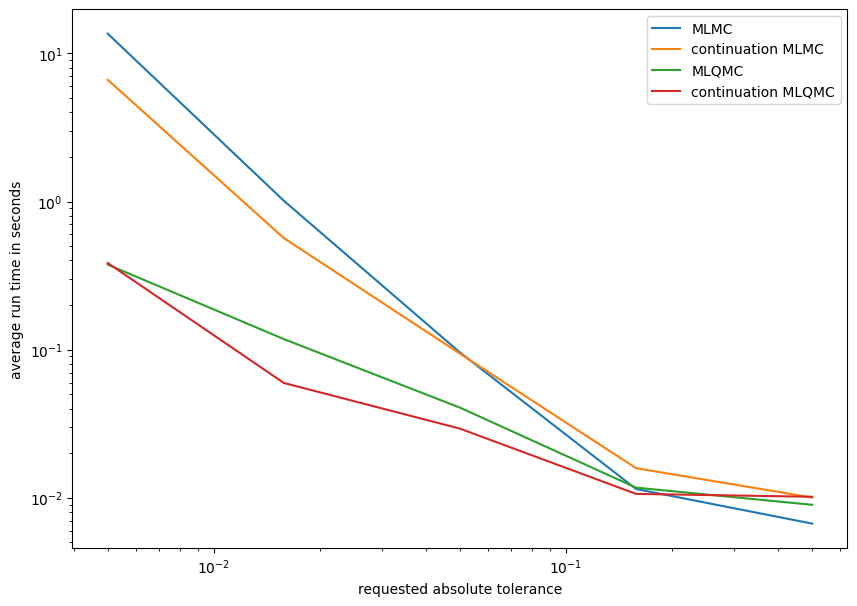

In [12]:
plt.figure(figsize=(10,7))
plt.plot(tolerances, avg_time[0], label="MLMC")
plt.plot(tolerances, avg_time[1], label="continuation MLMC")
plt.plot(tolerances, avg_time[2], label="MLQMC")
plt.plot(tolerances, avg_time[3], label="continuation MLQMC")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("requested absolute tolerance")
plt.ylabel("average run time in seconds")
plt.legend();

In [13]:
max_levels = {}
for method in range(4):
    levels_rep = np.array([levels[len(tolerances)-1, r][method] for r in range(repetitions)])
    max_levels[method] = [np.count_nonzero(levels_rep == level)/repetitions for level in range(15)]

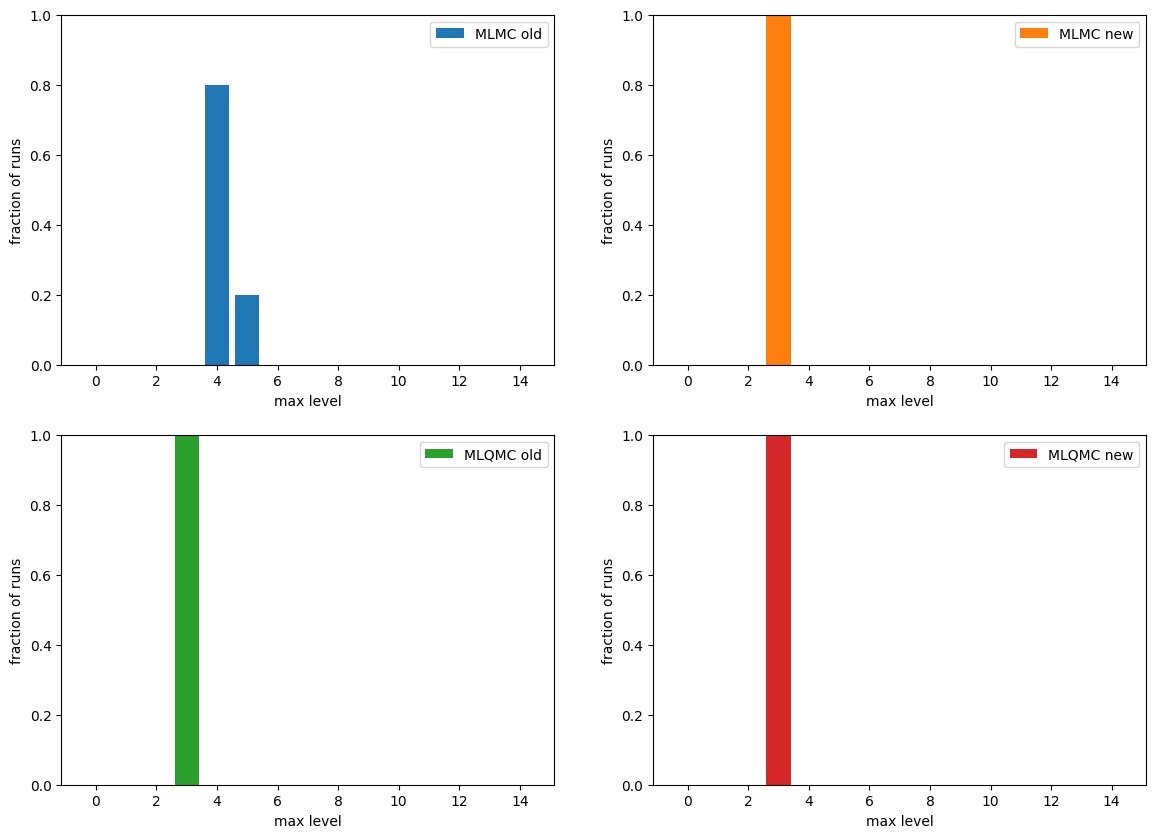

In [14]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1); plt.bar(range(15), max_levels[0], label="MLMC old", color="C0"); plt.xlabel("max level"); plt.ylabel("fraction of runs"); plt.ylim(0, 1); plt.legend()
plt.subplot(2,2,2); plt.bar(range(15), max_levels[1], label="MLMC new", color="C1"); plt.xlabel("max level"); plt.ylabel("fraction of runs"); plt.ylim(0, 1); plt.legend()
plt.subplot(2,2,3); plt.bar(range(15), max_levels[2], label="MLQMC old", color="C2"); plt.xlabel("max level"); plt.ylabel("fraction of runs"); plt.ylim(0, 1); plt.legend()
plt.subplot(2,2,4); plt.bar(range(15), max_levels[3], label="MLQMC new", color="C3"); plt.xlabel("max level"); plt.ylabel("fraction of runs"); plt.ylim(0, 1); plt.legend();